In [1]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import scipy.stats
from tqdm import tqdm
from autoencoder_helper import gaussian_1d

seed = 10000
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

load = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
class Net(nn.Module):
    
    def __init__(self, n_input, n_output):
        super(Net, self).__init__()
        
        # encoder
        self.enc1 = nn.Linear(n_input,50)
        self.enc2 = nn.Linear(50,25)
        self.enc3 = nn.Linear(25,10)
        
        # decoder
        self.dec1 = nn.Linear(10, 25)
        self.dec2 = nn.Linear(25, 50)
        self.dec3 = nn.Linear(50, n_output)
        
        self.dropout = nn.Dropout(p=0.5)
        
#     def forward(self, x):
#         x = torch.sigmoid(self.enc1(x)) 
#         x = torch.sigmoid(self.enc2(x))
#         x = torch.sigmoid(self.enc3(x))
#         x = torch.sigmoid(self.enc4(x))
        
#         x = torch.sigmoid(self.dec1(x))
#         x = torch.sigmoid(self.dec2(x))
#         x = torch.sigmoid(self.dec3(x))
#         x = self.dec4(x)
#         return x

    def forward(self, x):
        x = self.dropout(torch.relu(self.enc1(x)))
        x = self.dropout(torch.relu(self.enc2(x)))
        x = self.dropout(torch.relu(self.enc3(x)))
        x = self.dropout(torch.relu(self.dec1(x)))
        x = self.dropout(torch.relu(self.dec2(x)))
        x = self.dec3(x)
        return x

In [14]:
#generate training data of uni and bimodal Gaussians

n_input = 200
n_output = n_input # n_output == n_input for autoencoders

n_train_data = 20000
train_data = np.empty((0,n_input), float)
test_data = np.empty((0,n_input), float)

for i in tqdm(range(n_train_data)):
    
    # unimodal train data
    mean1 = random.uniform(-10,10)
    std1 = random.uniform(1,3)
    uni_data1 = np.random.normal(mean1, std1, size = (1,n_input))
    train_data = np.append(train_data, uni_data1, axis = 0 )
    
    # unimodal test data
    mean2 = random.uniform(-10,10)
    std2 = random.uniform(1,3)
    uni_data2 = np.random.normal(mean2, std2, size = (1,n_input))
    test_data = np.append(test_data, uni_data2, axis = 0 )
    
#     #bimodal train data
#     mean1 = random.uniform(-10,10)
#     mean2 = random.uniform(-10,10)
#     std1 = random.uniform(1,3)
#     std2 = random.uniform(1,3)
#     x1 = np.random.normal(mean1, std1, size=(1,n_input//2))
#     x2 = np.random.normal(mean2, std2, size=(1,n_input//2))
#     bi_data1 = np.concatenate([x1,x2], axis =1)
#     train_data = np.append(train_data, bi_data1, axis= 0)
    
#     #bimodal test data
#     mean1 = random.uniform(-10,10)
#     mean2 = random.uniform(-10,10)
#     std1 = random.uniform(1,3)
#     std2 = random.uniform(1,3)
#     x1 = np.random.normal(mean1, std1, size=(1,n_input//2))
#     x2 = np.random.normal(mean2, std2, size=(1,n_input//2))
#     bi_data2 = np.concatenate([x1,x2], axis =1)
#     test_data = np.append(test_data, bi_data2, axis=0)

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [02:55<00:00, 113.97it/s]


In [15]:
train_data = train_data.astype(np.float32)
train_data = np.sort(train_data, axis=1)
train_mean = np.mean(train_data, axis=1)
train_std = np.std(train_data, axis=1)
train_data = torch.from_numpy(train_data)
train_data = train_data.to(device)
for i in range(train_data.shape[0]):
    train_data[i,:] = (train_data[i,:] - train_mean[i] ) / train_std[i]

test_data = test_data.astype(np.float32)
test_data = np.sort(test_data, axis=1)
test_mean = np.mean(test_data, axis=1)
test_std = np.std(test_data, axis=1)
test_data = torch.from_numpy(test_data)
test_data = test_data.to(device)
for i in range(train_data.shape[0]):
    test_data[i,:] = (test_data[i,:] - test_mean[i] ) / test_std[i]

In [5]:
epochs_end = 10000
epochs_start = 0
batch_size = 32
n_batch = n_train_data//batch_size
net = Net(n_input, n_output)
net = net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_func = nn.MSELoss()
net.train()

Net(
  (enc1): Linear(in_features=200, out_features=50, bias=True)
  (enc2): Linear(in_features=50, out_features=25, bias=True)
  (enc3): Linear(in_features=25, out_features=10, bias=True)
  (dec1): Linear(in_features=10, out_features=25, bias=True)
  (dec2): Linear(in_features=25, out_features=50, bias=True)
  (dec3): Linear(in_features=50, out_features=200, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [16]:
if load:
    net = Net(n_input, n_output)
    net = net.to(device)
    checkpoint = torch.load('model_ll_dropout_lr_0.001.pt')
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epochs_start = checkpoint['epoch']

In [7]:
# for e in range(epochs_start, epochs_end):

#     print("Current epoch number: {}".format(e))
#     for i in range(n_batch):
#         mini_batch_data = train_data[i*batch_size:(i+1)*batch_size, :]
#         mini_batch_data = mini_batch_data.to(device)
#         prediction = net(mini_batch_data)
#         #loss = likelihood_loss(prediction, i) 
#         loss = loss_func(prediction, mini_batch_data)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
    
#     if (e+1) % 10 == 0 :
#         net.eval()
#         train_pred = net(train_data)
#         #loss = likelihood_loss(full_pred, -1, train=False)
#         loss = loss_func(train_pred, train_data)
#         train_loss = loss.item()
        
#         test_pred = net(test_data)
#         #loss = likelihood_loss(full_pred, -1, train=False)
#         loss = loss_func(test_pred, test_data)
#         test_loss = loss.item()
#         net.train()
        
#         print("Epoch {:d}, train loss: {:f}, test loss: {:f}".format(e,train_loss,test_loss))
# #         torch.save({
# #             'epoch': e,
# #             'model_state_dict': net.state_dict(),
# #             'optimizer_state_dict': optimizer.state_dict()
# #         }, 'model.pt')
        


In [17]:
for e in range(epochs_start, epochs_end):

    prediction = net(train_data)
    loss = loss_func(prediction, train_data)
    train_loss = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (e+1) % 100 == 0 :
        net.eval()
        print("Current epoch number: {}".format(e))
        test_pred = net(test_data)
        loss = loss_func(test_pred, test_data)
        test_loss = loss.item()
        net.train()
        
        print("Epoch {:d}, train loss: {:f}, test loss: {:f}".format(e,train_loss,test_loss))
#         torch.save({
#             'epoch': e,
#             'model_state_dict': net.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'test_loss': test_loss,
#             'train_loss': train_loss
#         }, 'model_ll_dropout_lr_0.001.pt')
        


Current epoch number: 99
Epoch 99, train loss: 0.007596, test loss: 0.007596
Current epoch number: 199
Epoch 199, train loss: 0.031118, test loss: 0.007391
Current epoch number: 299
Epoch 299, train loss: 0.025782, test loss: 0.007309
Current epoch number: 399
Epoch 399, train loss: 0.023631, test loss: 0.007258
Current epoch number: 499
Epoch 499, train loss: 0.022168, test loss: 0.007236
Current epoch number: 599
Epoch 599, train loss: 0.020888, test loss: 0.007234
Current epoch number: 699
Epoch 699, train loss: 0.020285, test loss: 0.007197
Current epoch number: 799
Epoch 799, train loss: 0.019765, test loss: 0.007227
Current epoch number: 899
Epoch 899, train loss: 0.019052, test loss: 0.007177
Current epoch number: 999
Epoch 999, train loss: 0.018876, test loss: 0.007181
Current epoch number: 1099
Epoch 1099, train loss: 0.018284, test loss: 0.007189
Current epoch number: 1199
Epoch 1199, train loss: 0.017830, test loss: 0.007184
Current epoch number: 1299
Epoch 1299, train loss:

In [18]:
net.eval()
pred = net(test_data)

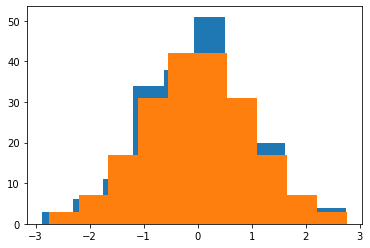

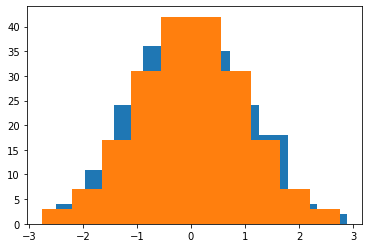

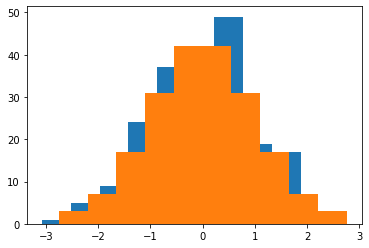

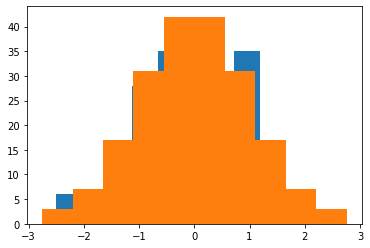

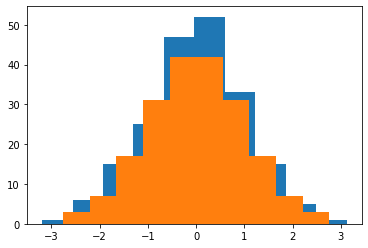

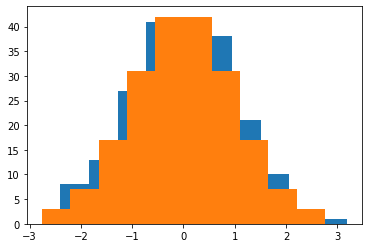

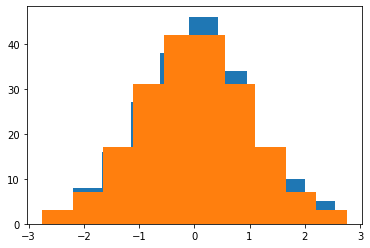

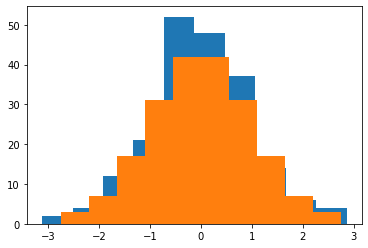

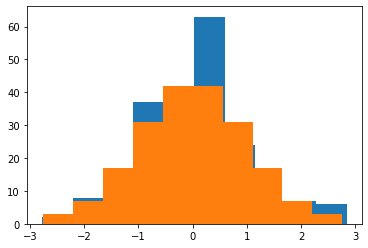

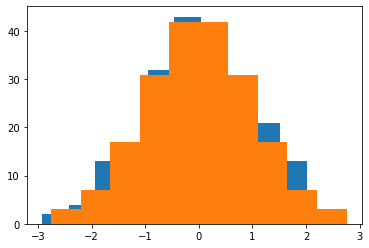

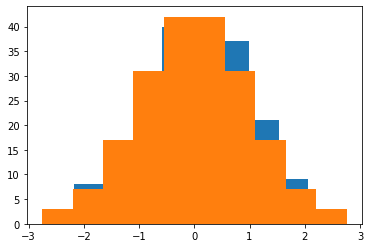

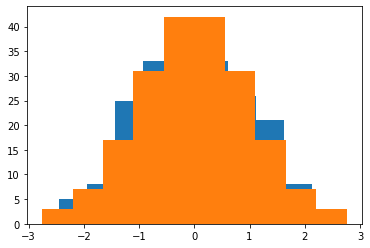

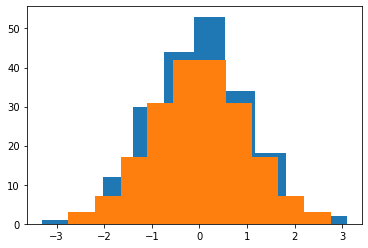

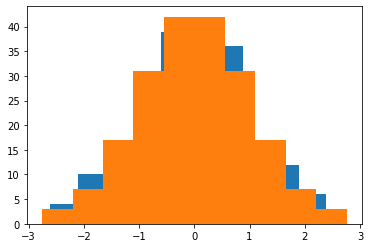

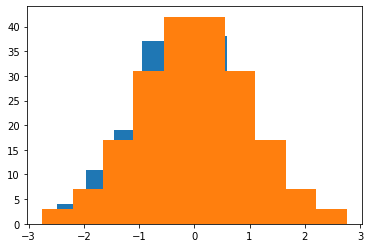

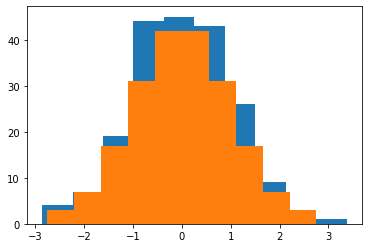

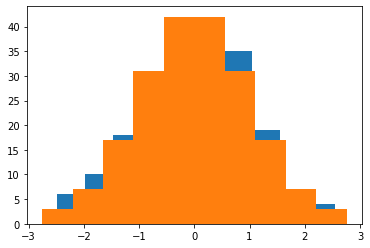

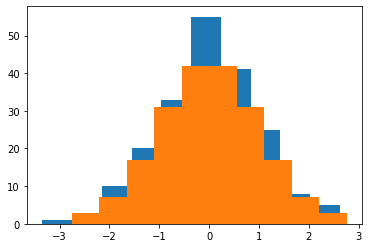

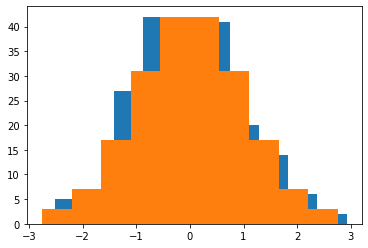

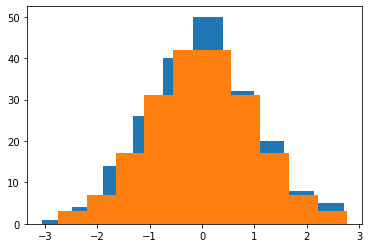

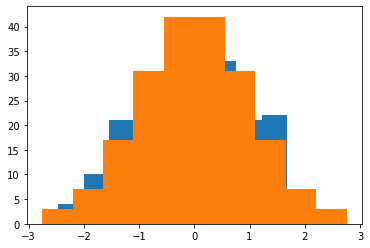

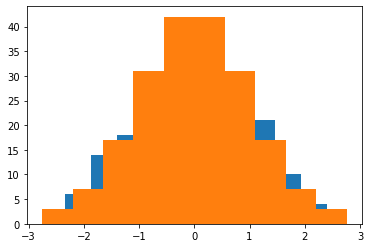

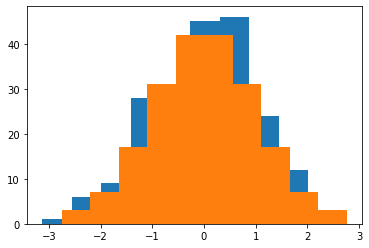

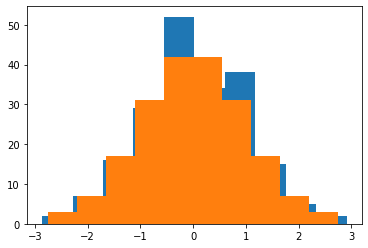

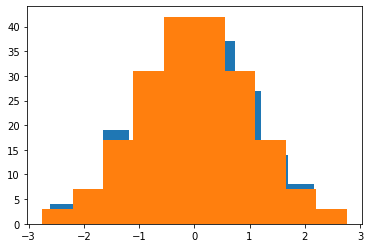

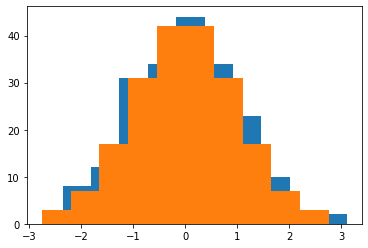

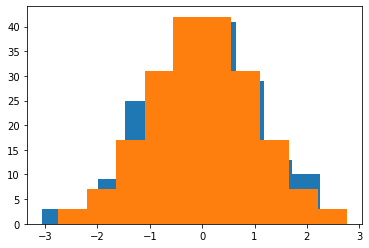

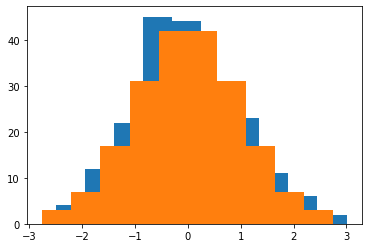

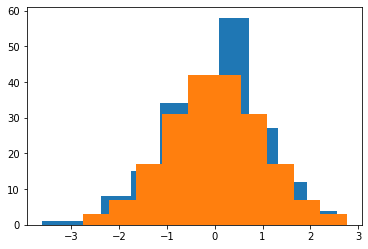

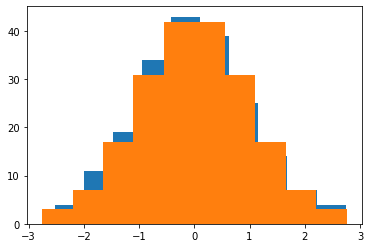

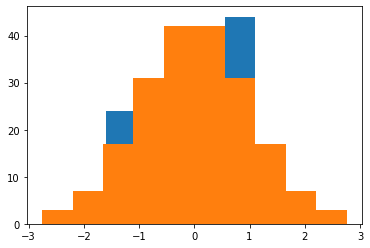

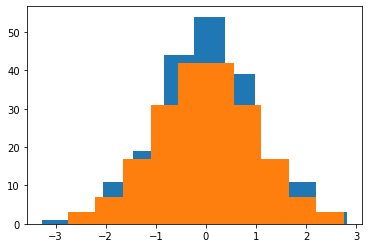

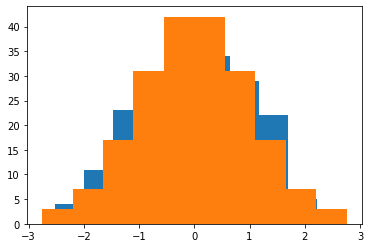

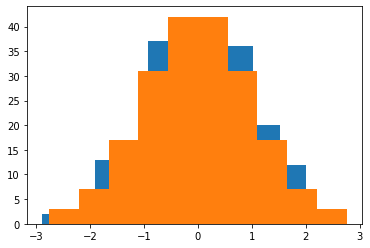

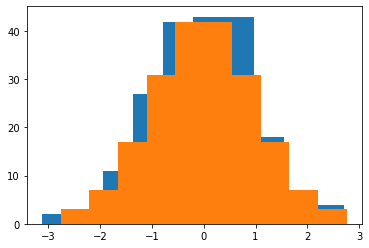

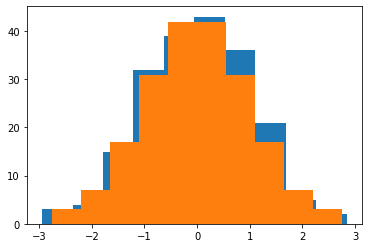

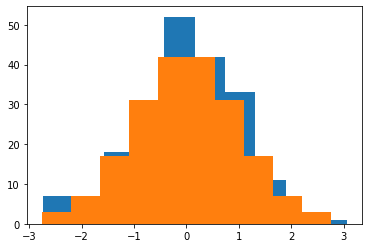

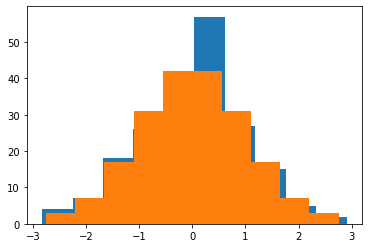

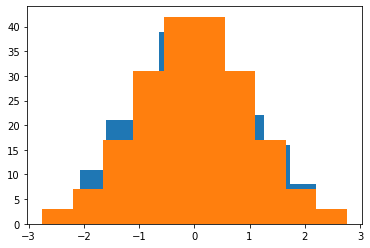

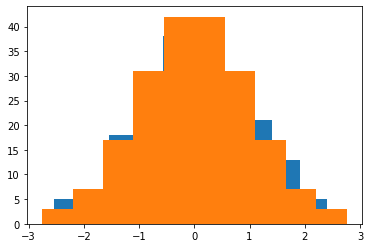

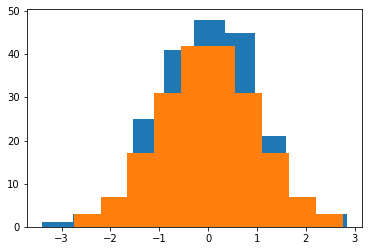

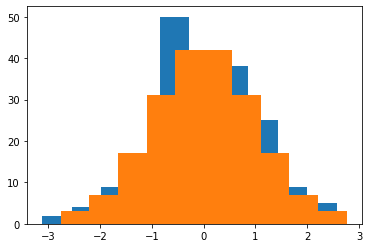

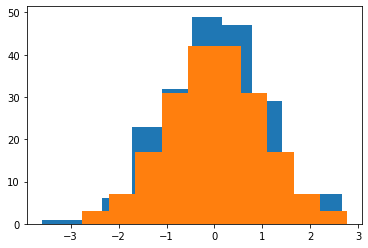

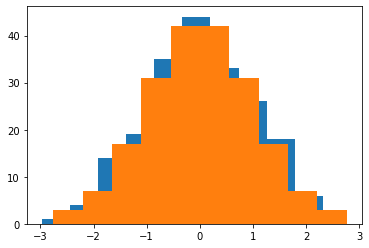

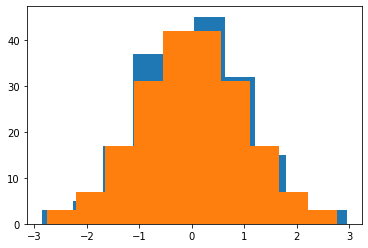

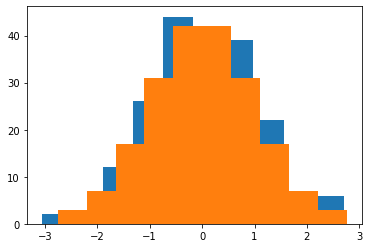

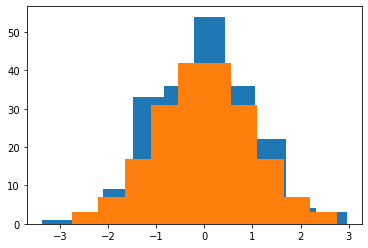

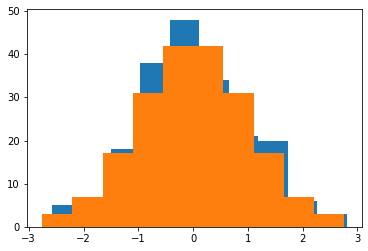

In [19]:
for i in np.arange(0,1000,21):
    
    plt.hist(test_data[i].cpu())
    plt.hist(pred.detach().cpu().numpy()[i])
    plt.show()